# 2 Linear Regression - Cross Validation (Python)

## 2.1 Utility Functions
Rewrite the code in the previous tutorial as functions, and expand them to *deg* degree with *deg+1* terms.
- *polynomial_evaluate(x,w)* evaluates the polynomial function (defined by the weights $w$) at $x$ locations.
- *polynomial_fit(x,deg)* fits a new polynomial (defined by $w$) with a fixed (highest) degree *deg*, to the given data pairs [$x$, $t$].
- *polynomial_basis(x,deg)* constructs terms of polynomial function of given $x$ with a degree of *deg*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# functions based on the previous tutorial
def polynomial_evaluate(x, w):
    X = polynomial_basis(x, w.size-1)
    t = np.matmul(X, w)
    return t

def polynomial_fit(x, t, deg):
    X = polynomial_basis(x, deg)
    w = np.linalg.lstsq(X, t, rcond=None)
    return w[0]

def polynomial_basis(x, deg):
    X = np.power(np.reshape(x,[-1,1]), np.linspace(deg,0,deg+1))
    return X

def rms_error(residuals):
    return np.sqrt(np.mean(np.square(residuals)))


# test
X = polynomial_basis(np.array([.1,.2,.3,.4,.5]), 3)
print(X)

[[0.001 0.01  0.1   1.   ]
 [0.008 0.04  0.2   1.   ]
 [0.027 0.09  0.3   1.   ]
 [0.064 0.16  0.4   1.   ]
 [0.125 0.25  0.5   1.   ]]


## 2.2 Data
In this tutorial, the true model here is a polynomial with a degree of 4:

\begin{equation}
t = w_3x^3 + w_2x^2 + w_1x +w_0
\end{equation}

with weights $$\textbf{w}=\begin{vmatrix}4 & 3 & 2 & 1\end{vmatrix}^T$$

*n* observed data are sampled as follows:

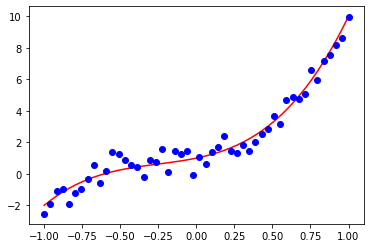

In [2]:
# model
w = np.reshape([4, 3, 2, 1], [-1, 1])

# sample locations
n = 50
x = np.linspace(-1,1,n)

# observed target data
std_noise = 0.5
t = polynomial_evaluate(x, w)
t_observed = t + np.random.normal(0,std_noise,[n,1])

# plot
plt.plot(x,t,'r')
plt.plot(x,t_observed,'bo')

Additionally, sample *n_holdout* holdout data that will not be used to fit the model:

In [3]:
# holdout (also observed) data
n_holdout = 30
x_holdout = np.linspace(-1,1,n_holdout)
t_holdout = polynomial_evaluate(x_holdout, w) + np.random.normal(0,std_noise,[n_holdout,1])

## 2.3 Underfitting and Overfitting
First, try to fit the following polynomial models, the first of which is a straight line:

\begin{equation}
t_{deg=1} = w_1x + w_0
\end{equation}

\begin{equation}
t_{deg=2} = w_2x^2 + w_1x + w_0
\end{equation}

\begin{equation}
t_{deg=3} = w_3x^3 + w_2x^2 + w_1x + w_0
\end{equation}

$$\cdots$$

\begin{equation}
t_{deg=m} = w_mx^m + \cdots + w_3x^3 + w_2x^2 + w_1x + w_0
\end{equation}

In [4]:
# first, fit the polynomials
degrees = [1,2,3,4,5,10,20,30]  # examples of degrees
w_estimates = []
t_estimates = []
for idx in range(len(degrees)):
    w_estimates.append(polynomial_fit(x, t_observed, deg=degrees[idx]))
    t_estimates.append(polynomial_evaluate(x, w_estimates[idx]))
    
    # residuals and root-mean-square errors
    Residuals = t_estimates[idx]-t_observed
    SR = np.sum(np.square(Residuals))
    RMSE = rms_error(Residuals)
    print([degrees[idx],SR,RMSE])

[1, 74.72943695405607, 1.222533737399963]
[2, 40.7632977733088, 0.902920791357789]
[3, 13.020498727665302, 0.5103038061324902]
[4, 12.778657505365585, 0.5055424315597176]
[5, 12.475289292186131, 0.49950554135437036]
[10, 10.790196004501091, 0.4645470052535285]
[20, 7.5908306149299065, 0.38963651304593894]
[30, 5.256043026763938, 0.32422347314048494]


Now, plot each fitted curve to compare, for example:

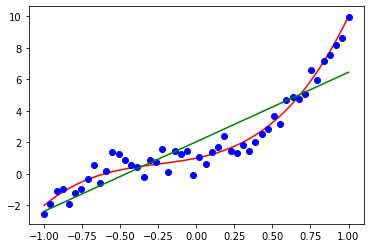

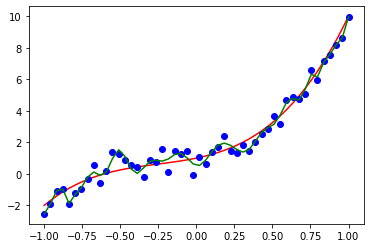

In [5]:
plt.figure()
idx = degrees.index(1)
plt.plot(x,t,'r')
plt.plot(x,t_observed,'bo')
plt.plot(x,t_estimates[idx],'g')

plt.figure()
idx = degrees.index(30)
plt.plot(x,t,'r')
plt.plot(x,t_observed,'bo')
plt.plot(x,t_estimates[idx],'g')

## 2.3 K-fold Cross-validation
K-fold cross-validation splits the original sample into k equal-sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The training-testing process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce an estimation of the model performance.

It is of great importance to understand the difference between training- and testing errors. Conceptually, the training error is to summarise the residuals between the fitted-model predicted targets and the observed ones which have been used for fitting the model, whilst the testing error is the difference based on an independent set of data that have been *unseen* to the model fitting process, which estimates the optimal model weights. The concept of "unseen" is also useful in distinguishing different types of errors in cross-validation experiments.

In [6]:
import random


# shuffle data first
indices = [idx for idx in range(n)]
random.seed(1)
random.shuffle(indices)

# set up a 5-fold cross-validation
k = 5
size_fold = int(n/k)
deg = 4  # model to fit

Residuals_train = []
Residuals_test = []
for idx_fold in range(k):  # fold index
    # set indices for training data and test data
    indices_test = indices[idx_fold*size_fold:(idx_fold+1)*size_fold]
    indices_train = list(set(indices) - set(indices_test))
    
    # training    
    w_train = polynomial_fit(x[indices_train], t_observed[indices_train], deg=deg)
    t_train = polynomial_evaluate(x[indices_train], w_train)    
    Residuals_train.append(t_train-t_observed[indices_train])
    # testing
    t_test = polynomial_evaluate(x[indices_test], w_train)
    Residuals_test.append(t_test-t_observed[indices_test])

# calculating training and testing errors
RMSE_train = rms_error(np.concatenate(Residuals_train, axis=0))
RMSE_test = rms_error(np.concatenate(Residuals_test, axis=0))
print(RMSE_train) 
print(RMSE_test)

0.4976593139510383
0.5734202763560762


## Questions
- Find an optimal degree with respect to the testing error.
- What can reduce training error and/or testing error?
- Given a fixed set of observed data, is it possible to find a polynomial that produces smaller testing error than the underlying "true" model?
- What is the difference between an overfitted polynomial model and an overfitted cross-validation model?

## 2.4 Generalisability
Different from the testing error obtained in each fold, a better estimate of the generalisation ability can be quantified by the testing error on holdout data.

In [7]:
# build the model using all the data and the selected (optimised) hyperparameter degree
deg = 4
w_train = polynomial_fit(x, t_observed, deg=deg)
t_train = polynomial_evaluate(x, w_train)
RMSE_train = rms_error(t_train-t_observed)
t_test = polynomial_evaluate(x_holdout, w_train)
RMSE_test = rms_error(t_test-t_holdout)
print(RMSE_train) 
print(RMSE_test)

0.5055424315597176
0.5398329824140627


## Questions
- Adding norm-2 regularisation to the model fitting, does this help?
- What is the required data size for training and testing. How are training and testing errors affected by the data size? 
- Compare testing errors in cross-validation and those based on holdout data. Under what conditions, they are different?